In [2]:
import matplotlib.pyplot as plt
import astricaltools as at
import numpy as np
import pandas as pd

from astropy import stats
import astropy.units as u
from astropy.io import fits
from astropy.table import vstack, Table
from astropy.time import Time
from astropy.timeseries import TimeSeries
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, Angle

In [3]:
file_numbers = range(1, 10)  # da 001 a 009
base_path = "astri_{:03d}_43_009_00002_R_201023_004_0201_SEB.lv0"  # pattern del nome file

dfs = []  # lista per accumulare i DataFrame
print("\n")
for i in file_numbers:
    filename = base_path.format(i)
    print(f"{filename}")

    with at.io.fits.AstriFits(filename) as hdul:
        data = hdul[1].data

        # Conversione dei campi
        time_ns = data["TIME_NS"].byteswap().newbyteorder().astype(np.int64)
        time_s  = data["TIME_S"].byteswap().newbyteorder().astype(np.int64)
        event   = data["EVTNUM"].byteswap().newbyteorder().astype(np.int64)
        mcrun   = data["MCRUNNUM"].byteswap().newbyteorder().astype(np.int64)
        time_abs = time_s * 10**9 + time_ns  # tempo assoluto in ns
        hg, lg, ttp = hdul.get_data('events', ['hi', 'lo', 'ttp'])
        time_abs = time_s * 10**9 + time_ns  # tempo assoluto in ns
            #creo il dataframe
        df = pd.DataFrame({
                "TIME_NS": time_ns,
                "TIME_S": time_s,
                "TIME_ABS": time_abs,
                "EVENT": event,
                "MCRUN": mcrun,
                "TEL_ID": i,
                "HG": list(hg),             
                "LG": list(lg),
                "TTP": list(ttp)
            })

        dfs.append(df)
df_all = pd.concat(dfs, ignore_index=True)
df_all_sorted= df_all.sort_values(by="TIME_ABS").reset_index(drop=True)
print(df_all.columns)
print(df_all_sorted.head())



astri_001_43_009_00002_R_201023_004_0201_SEB.lv0


astri_002_43_009_00002_R_201023_004_0201_SEB.lv0
astri_003_43_009_00002_R_201023_004_0201_SEB.lv0
astri_004_43_009_00002_R_201023_004_0201_SEB.lv0
astri_005_43_009_00002_R_201023_004_0201_SEB.lv0
astri_006_43_009_00002_R_201023_004_0201_SEB.lv0
astri_007_43_009_00002_R_201023_004_0201_SEB.lv0
astri_008_43_009_00002_R_201023_004_0201_SEB.lv0
astri_009_43_009_00002_R_201023_004_0201_SEB.lv0
Index(['TIME_NS', 'TIME_S', 'TIME_ABS', 'EVENT', 'MCRUN', 'TEL_ID', 'HG', 'LG',
       'TTP'],
      dtype='object')
   TIME_NS  TIME_S  TIME_ABS  EVENT   MCRUN  TEL_ID  \
0   238868       0    238868   1007  263210       2   
1  1029262       0   1029262   3519  263210       2   
2  1030456       0   1030456   3519  263210       9   
3  3274338       0   3274338   3803  263210       9   
4  3678725       0   3678725   3805  263210       2   

                                                  HG  \
0  [[2156, 2287, 2081, 2114, 2197, 2323, 2141, 22...   
1  [[2069, 2138, 2184, 2049, 2241, 2220, 2179, 2

mc=266033, ev=3109


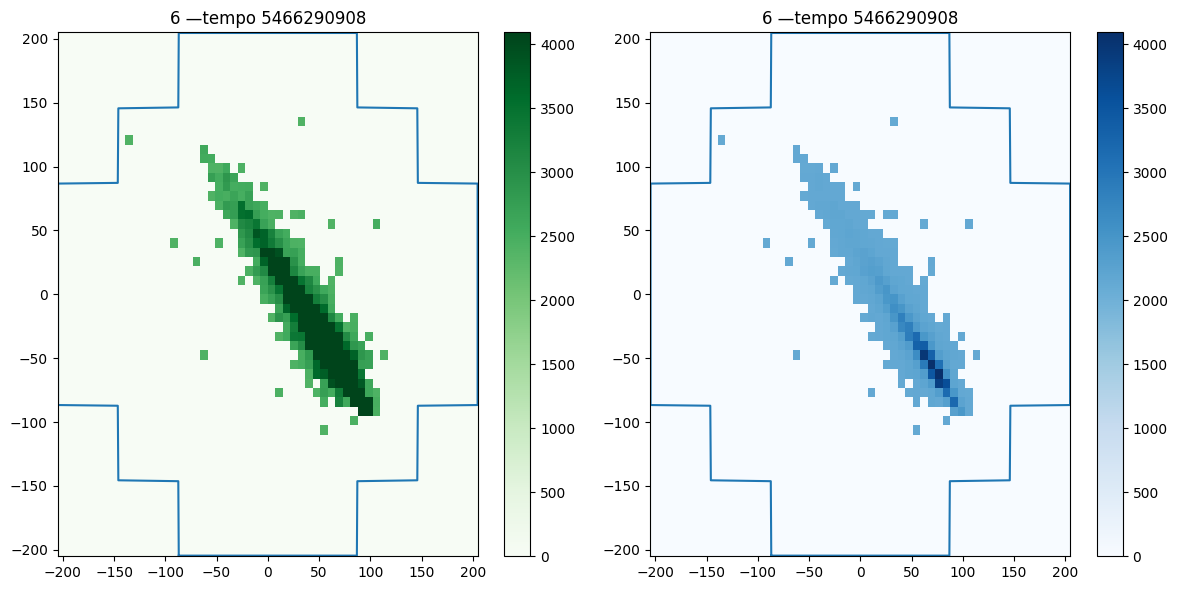

In [4]:
xfp, yfp = at.utils.camera.get_xy_footprint()
y_pix, x_pix = at.utils.camera.get_pixels_position_matrix().T
x_pix = at.reshape(x_pix)
y_pix = at.reshape(y_pix)

event_energies = df_all_sorted['HG'].apply(np.sum)
top_indices = np.argsort(event_energies)[-5:]
#i 3 eventi più energetici in assoluto tra tutti i file
for iev in top_indices[0:1]:
    print(f"mc={df_all_sorted['MCRUN'][iev]}, ev={df_all_sorted['EVENT'][iev]}")
    
    # ciclo sui primi eventi piu energetici
    #for iev in range(10):
    hgev = np.array(df_all_sorted['HG'])[iev]
    lgev = np.array(df_all_sorted['LG'])[iev]
    ttpev = np.array(df_all_sorted['TTP'])[iev]
            # filtro temporale
    pxmask =(hgev>2400) & (ttpev < 255)

            # sigma clipping per pulizia
            #hgev = stats.sigma_clip(hgev, sigma=4., cenfunc='mean').filled(0)
            #lgev = stats.sigma_clip(lgev, sigma=6., cenfunc='mean').filled(0)
            
            # plot
    fig, ax = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)            
    hl = ax[0].hist2d(x_pix[pxmask].flatten(),y_pix[pxmask].flatten(),
                          weights=hgev[pxmask].flatten(),range=((-205, 205), (-205, 205)),
                          bins=7*8, cmap='Greens')
    hh = ax[1].hist2d(x_pix[pxmask].flatten(),y_pix[pxmask].flatten(),
                          weights=lgev[pxmask].flatten(),range=((-205, 205), (-205, 205)),
                          bins=7*8, cmap='Blues')
    fig.colorbar(hl[3], ax=ax[0])
    fig.colorbar(hh[3], ax=ax[1])
    for ai in ax:
            ai.plot(xfp, yfp)
            ai.set_title(f"{df_all_sorted['TEL_ID'][iev]} —tempo {df_all_sorted['TIME_ABS'][iev]}")

    plt.show()

#print(np.shape(top_indices))
#print(event_energies)

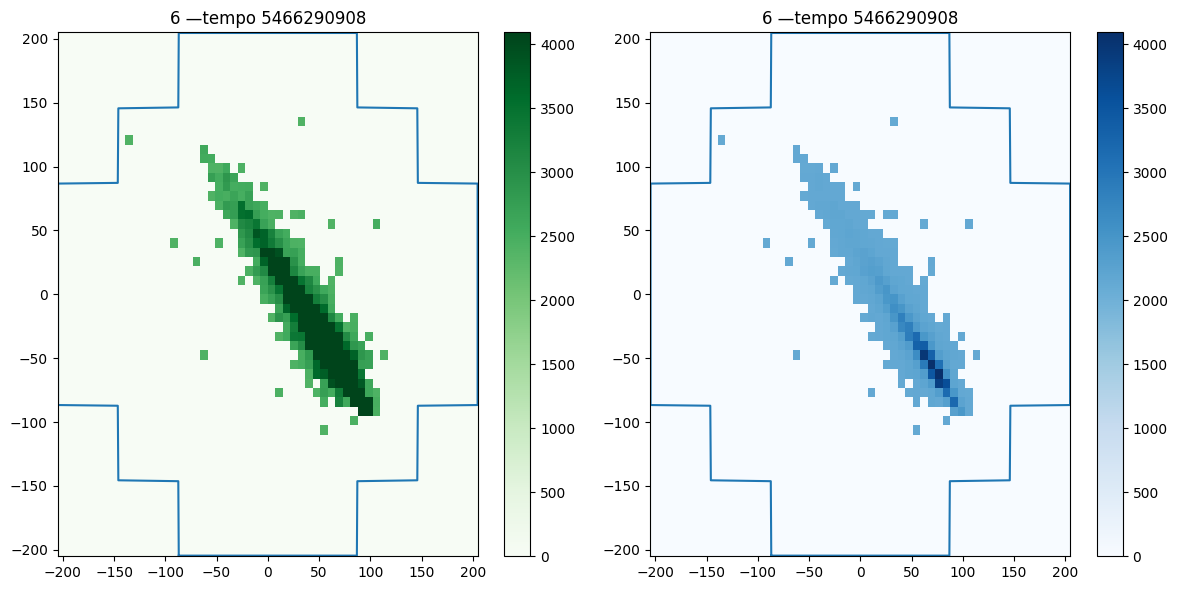

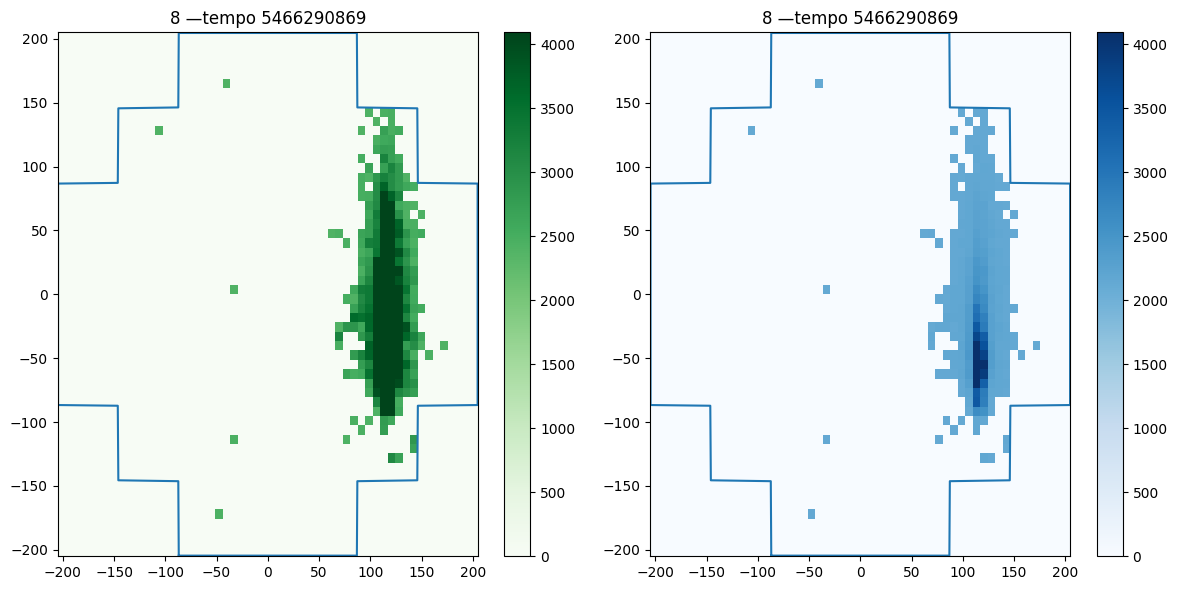

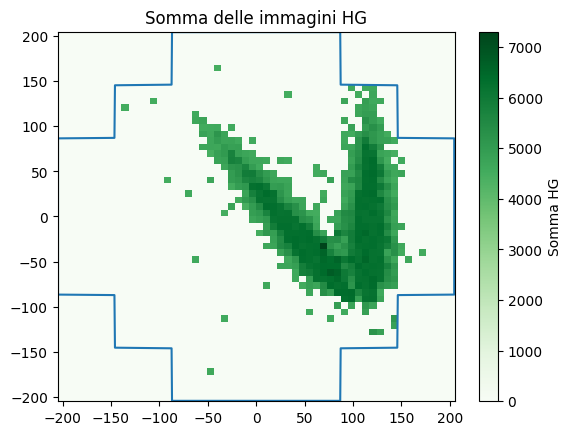

In [5]:
weights = np.zeros_like(np.array(df_all_sorted['HG'])[0])
mask_tot = np.zeros((37, 64), dtype=bool)



for iev in top_indices[0:2]:
    hgev = np.array(df_all_sorted['HG'])[iev]
    weights += hgev  # somma elemento per elemento
    lgev = np.array(df_all_sorted['LG'])[iev]
    ttpev = np.array(df_all_sorted['TTP'])[iev]
    # filtro temporale
    pxmask =(hgev>2400) & (ttpev < 255)
    mask_tot |= pxmask      # somma logica (OR)
            # sigma clipping per pulizia
            #hgev = stats.sigma_clip(hgev, sigma=4., cenfunc='mean').filled(0)
            #lgev = stats.sigma_clip(lgev, sigma=6., cenfunc='mean').filled(0)
            
            # plot
    fig, ax = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)            
    hl = ax[0].hist2d(x_pix[pxmask].flatten(),y_pix[pxmask].flatten(),
                          weights=hgev[pxmask].flatten(),range=((-205, 205), (-205, 205)),
                          bins=7*8, cmap='Greens')
    hh = ax[1].hist2d(x_pix[pxmask].flatten(),y_pix[pxmask].flatten(),
                          weights=lgev[pxmask].flatten(),range=((-205, 205), (-205, 205)),
                          bins=7*8, cmap='Blues')
    fig.colorbar(hl[3], ax=ax[0])
    fig.colorbar(hh[3], ax=ax[1])
    for ai in ax:
            ai.plot(xfp, yfp)
            ai.set_title(f"{df_all_sorted['TEL_ID'][iev]} —tempo {df_all_sorted['TIME_ABS'][iev]}")

    plt.show()
weights=np.array(weights)
plt.hist2d(x_pix[mask_tot].flatten(),y_pix[mask_tot].flatten(),
                          weights=weights[mask_tot].flatten(),range=((-205, 205), (-205, 205)),
                          bins=7*8, cmap='Greens')
plt.plot(xfp, yfp)
plt.colorbar(label='Somma HG')
plt.title('Somma delle immagini HG')
plt.show()


Index(['TIME_NS', 'TIME_S', 'TIME_ABS', 'EVENT', 'MCRUN', 'TEL_ID', 'HG', 'LG',
       'TTP'],
      dtype='object')


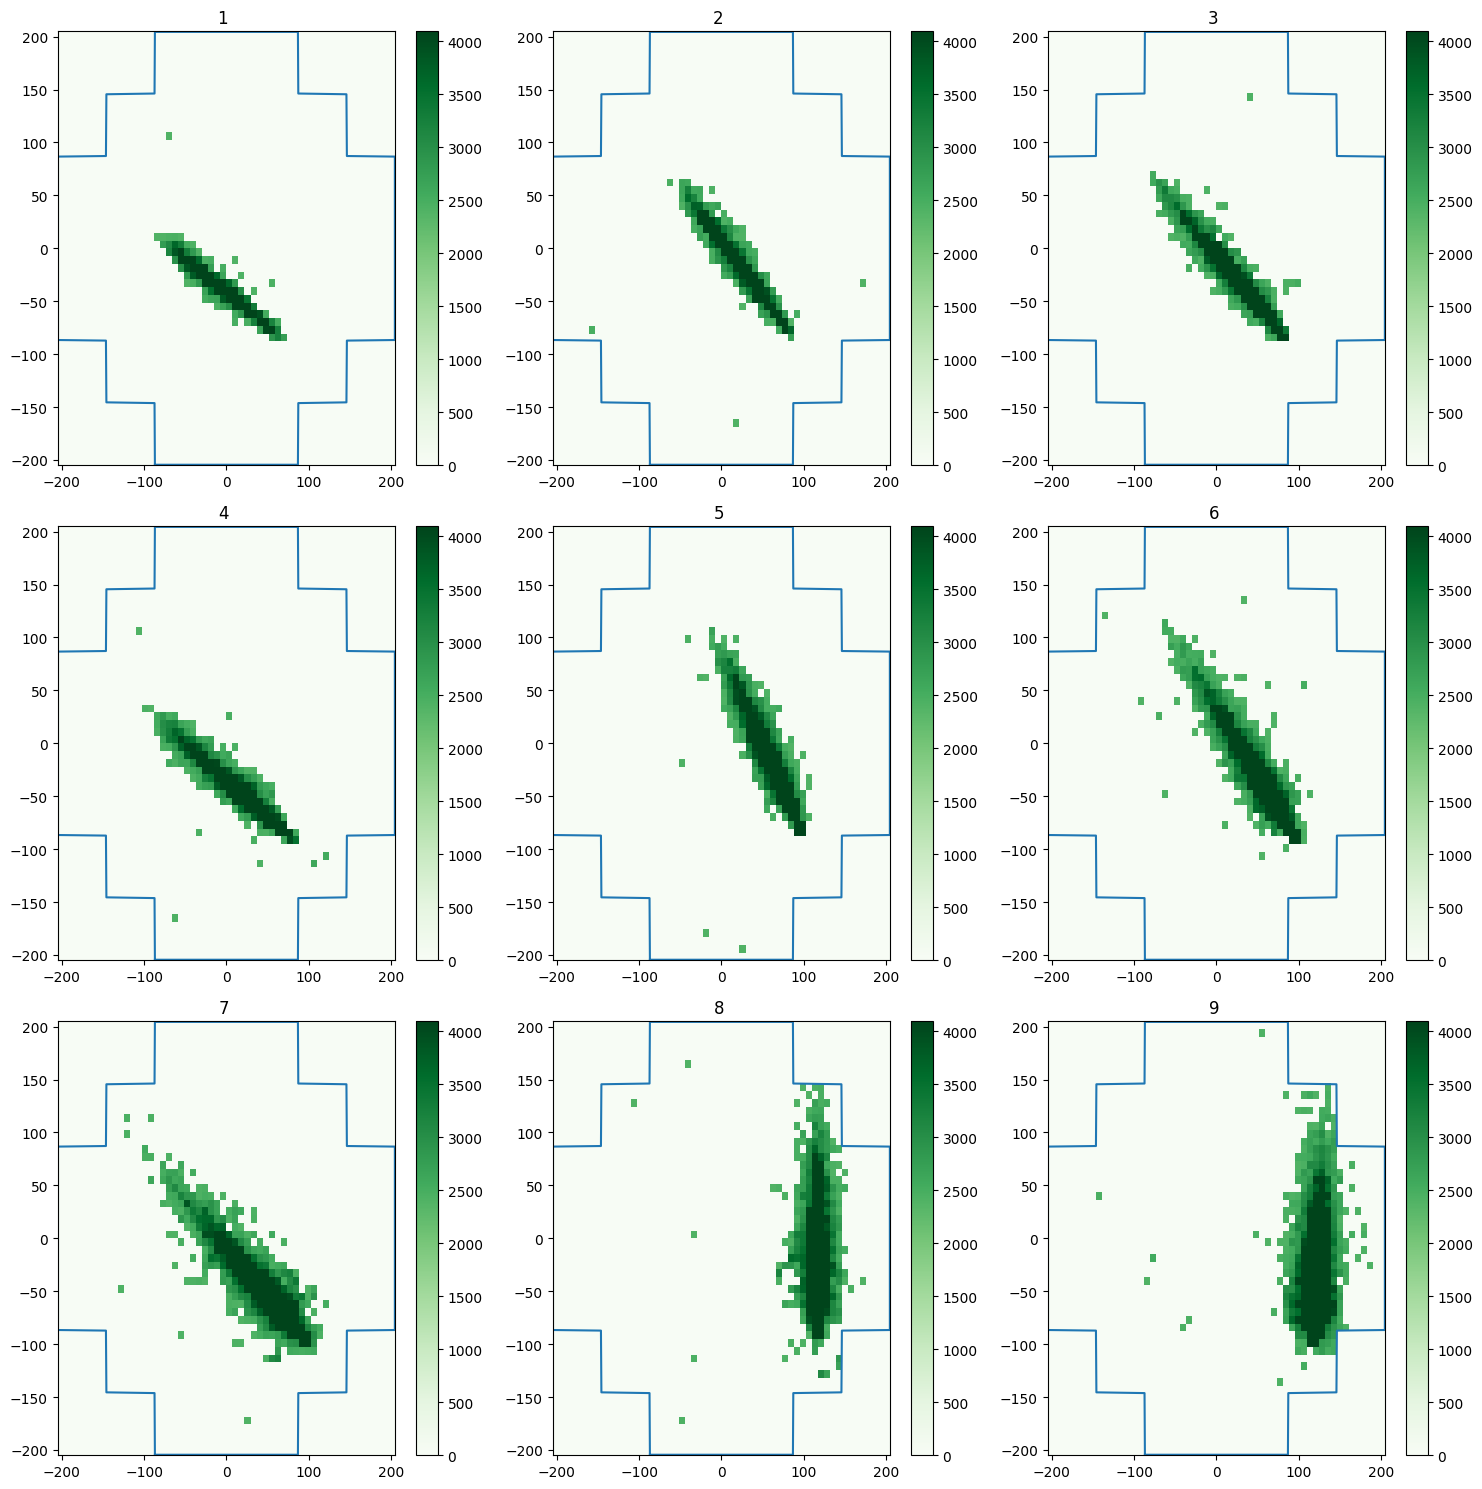

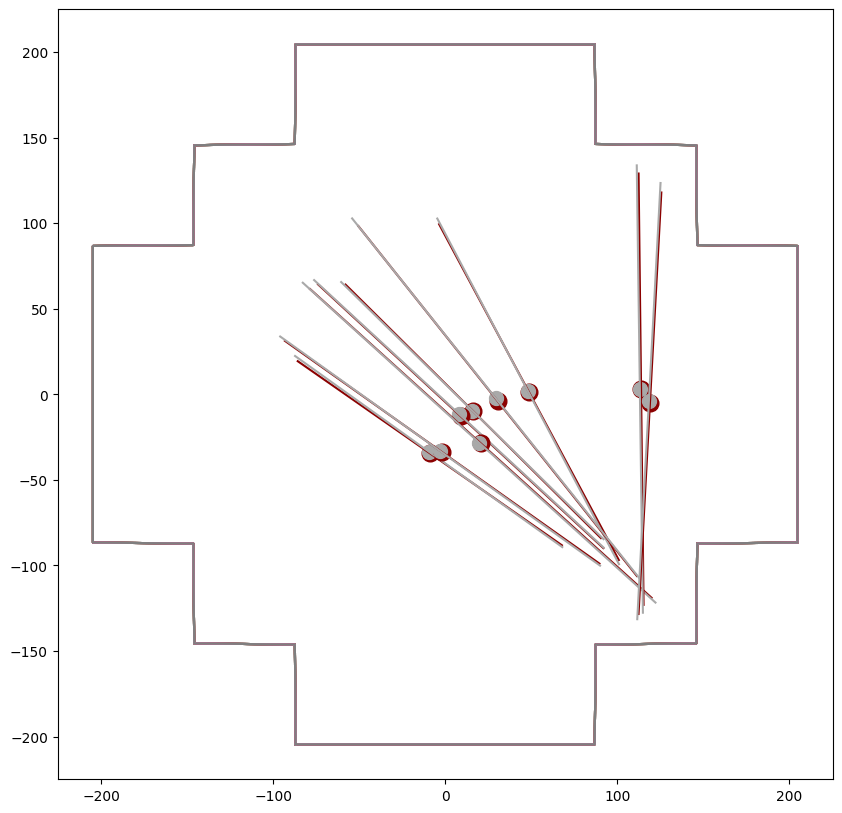

         TIME_NS  TIME_S    TIME_ABS
14811  466290239       5  5466290239
14810  466290070       5  5466290070
14813  466290499       5  5466290499
14815  466290902       5  5466290902
14812  466290420       5  5466290420
14816  466290908       5  5466290908
14818  466291410       5  5466291410
14814  466290869       5  5466290869
14817  466291393       5  5466291393


In [25]:
#stampo lo stesso evento, che già conosco
target=3109
target_mc =266033
df_target= df_all_sorted[
    (df_all_sorted['EVENT'] == target) &
    (df_all_sorted['MCRUN'] == target_mc)
]
df_target=df_target.sort_values(by='TEL_ID')
print(df_target.columns)
peso = np.zeros_like(np.array(df_all_sorted['HG'])[0])
mask_tot = np.zeros((37, 64), dtype=bool)


fig, axes = plt.subplots(3, 3, figsize=(15, 15), tight_layout=True)

for itel in range(9):

    hgev = np.array(df_target['HG'])[itel]
    peso += hgev  # somma elemento per elemento

    lgev = np.array(df_target['LG'])[itel]
    ttpev = np.array(df_target['TTP'])[itel]
    # filtro temporale
    pxmask =(hgev>2400) & (ttpev < 255)
    mask_tot |= pxmask      # somma logica (OR)
            # sigma clipping per pulizia
            #hgev = stats.sigma_clip(hgev, sigma=4., cenfunc='mean').filled(0)
            #lgev = stats.sigma_clip(lgev, sigma=6., cenfunc='mean').filled(0)
       
        # plot
    row = itel // 3  # calcola riga
    col = itel % 3   # calcola colonna
    ax = axes[row, col]
    hl = ax.hist2d(x_pix[pxmask].flatten(),y_pix[pxmask].flatten(),
                          weights=hgev[pxmask].flatten(),range=((-205, 205), (-205, 205)),
                          bins=7*8, cmap='Greens')
    '''
    hh = ax[1].hist2d(x_pix[pxmask].flatten(),y_pix[pxmask].flatten(),
                          weights=lgev[pxmask].flatten(),range=((-205, 205), (-205, 205)),
                          bins=7*8, cmap='Blues')
    '''
    fig.colorbar(hl[3], ax=ax)
    ax.plot(xfp, yfp)
    ax.set_title(f"{df_target['TEL_ID'].iloc[itel]} ")

plt.show()
#studio di uno stesso evento
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(xfp, yfp, 'k-', linewidth=1)
#raccolgo le rette
rette_hg=[]
rette_lg=[]
for itel in range(9):

    hgev = np.array(df_target['HG'])[itel]
    lgev = np.array(df_target['LG'])[itel]
    ttpev = np.array(df_target['TTP'])[itel]
    # filtro temporale
    pxmask =(hgev>2400) & (ttpev < 255)
    ax.plot(xfp, yfp)
    #centroidi
    meanx_hg = np.average(x_pix[pxmask].flatten(),weights=hgev[pxmask].flatten())
    meany_hg = np.average(y_pix[pxmask].flatten(),weights=hgev[pxmask].flatten())
    meanx_lg = np.average(x_pix[pxmask].flatten(),weights=lgev[pxmask].flatten())
    meany_lg = np.average(y_pix[pxmask].flatten(),weights=lgev[pxmask].flatten())
    #covarianze   
    cov_hg = np.cov([x_pix[pxmask].flatten(),y_pix[pxmask].flatten()],aweights=hgev[pxmask].flatten())            
    cov_lg = np.cov([x_pix[pxmask].flatten(), y_pix[pxmask].flatten()],aweights=lgev[pxmask].flatten())
            
    #print(cov_hg)
    stdx_hg,stdx_hg = np.sqrt(np.diagonal(cov_hg))
    stdx_lg,stdx_lg = np.sqrt(np.diagonal(cov_lg))

# Ellipsoid parameters from Covariance Matrix
    l1_hg=(cov_hg[0,0]+cov_hg[1,1])/2+np.sqrt( ((cov_hg[0,0]-cov_hg[1,1])/2)**2 + cov_hg[0,1]**2 )
    l2_hg= (cov_hg[0,0]+cov_hg[1,1])/2 -np.sqrt( ((cov_hg[0,0]-cov_hg[1,1])/2)**2 + cov_hg[0,1]**2 )
    theta_hg = np.arctan2(l1_hg - cov_hg[0,0], cov_hg[0,1])

    l1_lg= (cov_lg[0,0]+cov_lg[1,1])/2 + np.sqrt( ((cov_lg[0,0]-cov_lg[1,1])/2)**2 + cov_lg[0,1]**2 )
    l2_lg= (cov_lg[0,0]+cov_lg[1,1])/2 - np.sqrt( ((cov_lg[0,0]-cov_lg[1,1])/2)**2 + cov_lg[0,1]**2 )
    theta_lg = np.arctan2(l1_lg - cov_lg[0,0], cov_lg[0,1])
    #raccolgo le rette
    rette_hg.append({
        "p0": np.array([meanx_hg, meany_hg]),
        "d":  np.array([np.cos(theta_hg), np.sin(theta_hg)]),
        "tel": itel
    })
    rette_lg.append({
        "p0": np.array([meanx_lg, meany_lg]),
        "d":  np.array([np.cos(theta_lg), np.sin(theta_lg)]),
        "tel": itel
    })
    ax.plot(xfp, yfp)
            #centroidi
    ax.plot(meanx_hg, meany_hg, 'o',markersize=12, color='darkred')
    ax.plot(meanx_lg, meany_lg, 'o',markersize=10, color='darkgrey')
            #le rette
    ax.plot( [meanx_hg-2*np.sqrt(l1_hg)*np.cos(theta_hg),
                      meanx_hg+2*np.sqrt(l1_hg)*np.cos(theta_hg)],
                      [meany_hg-2*np.sqrt(l1_hg)*np.sin(theta_hg),meany_hg+
                       2*np.sqrt(l1_hg)*np.sin(theta_hg)],'-',color='darkred')
    ax.plot( [meanx_lg-2*np.sqrt(l1_lg)*np.cos(theta_lg),
                        meanx_lg+2*np.sqrt(l1_lg)*np.cos(theta_lg)],
                        [meany_lg-2*np.sqrt(l1_lg)*np.sin(theta_lg),
                        meany_lg+2*np.sqrt(l1_lg)*np.sin(theta_lg)],
                        '-', color='darkgrey')
plt.show()
print(df_target[["TIME_NS", "TIME_S","TIME_ABS"]])

In [18]:



#intersezione tra rette
def intersection(p1, d1, p2, d2):
    """
    p1, p2 = centroidi
    d1, d2 = direzioni 
    """
    A = np.array([d1, -d2]).T
    b = p2 - p1

    # determinante per capire se sono parallele
    det = np.linalg.det(A)
    if abs(det) < 1e-6:
        return None  
    # risolvi i parametri t
    t = np.linalg.solve(A, b)[0]

    # punto di intersezione
    return p1 + t * d1
#intersezioni di hg--------------------------------------
N = len(rette_hg)
inters_hg=[]
for i in range(N):
    p1=rette_hg[i]["p0"]
    d1 = rette_hg[i]["d"]
    for j in range(i+1, N):
        p2=rette_hg[j]["p0"]
        d2 = rette_hg[j]["d"]
        P = intersection(p1, d1, p2, d2)
        if P is not None:
            inters_hg.append(P)
inters_hg = np.array(inters_hg)


v_hg = []
eps=8.#da definire
for i, p in enumerate(inters_hg):
    # distanza p da tutte le altre
    d = np.sqrt(np.sum((inters_hg - p)**2, axis=1))
    # quante intersezioni cadono entro il raggio
    n = np.sum(d < eps)
    # se abbastanza intersezioni vicine 
    if n >= 3:
        v_hg.append(p)

v_hg = np.array(v_hg)
#intersezioni di lg---------------------------------------------
N = len(rette_lg)
inters_lg=[]
for i in range(N):
    p1=rette_lg[i]["p0"]
    d1 = rette_lg[i]["d"]
    for j in range(i+1, N):
        p2=rette_lg[j]["p0"]
        d2 = rette_lg[j]["d"]
        P = intersection(p1, d1, p2, d2)
        if P is not None:
            inters_lg.append(P)
inters_lg = np.array(inters_lg)


v_lg = []
eps=8.#da definire
for i, p in enumerate(inters_lg):
    # distanza p da tutte le altre
    d = np.sqrt(np.sum((inters_lg - p)**2, axis=1))
    # quante intersezioni cadono entro il raggio
    n = np.sum(d < eps)
    # se abbastanza intersezioni vicine → salva
    if n >= 3:
        v_lg.append(p)

v_lg = np.array(v_lg)

#calcolo media e mediana di lg e hg
centro_hg = np.mean(v_hg, axis=0)
median_hg = np.median(v_hg, axis=0)

centro_lg = np.mean(v_lg, axis=0)
median_lg = np.median(v_lg, axis=0)

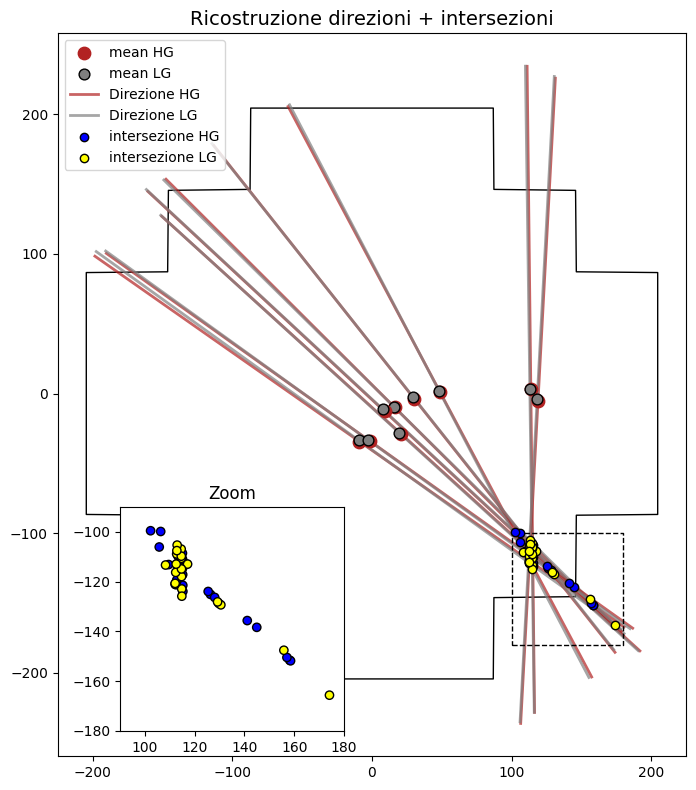

In [19]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(xfp, yfp, 'k-', linewidth=1)
xmin, xmax = np.min(xfp), np.max(xfp)
ymin, ymax = np.min(yfp), np.max(yfp)
diag = np.sqrt((xmax - xmin)**2 + (ymax - ymin)**2)
L = 0.4* diag
for itel in range(9):

    hgev = np.array(df_target['HG'])[itel]
    lgev = np.array(df_target['LG'])[itel]
    ttpev = np.array(df_target['TTP'])[itel]
    # filtro temporale
    pxmask =(hgev>2400) & (ttpev < 255)
    #centroidi
    meanx_hg = np.average(x_pix[pxmask].flatten(),weights=hgev[pxmask].flatten())
    meany_hg = np.average(y_pix[pxmask].flatten(),weights=hgev[pxmask].flatten())

    meanx_lg = np.average(x_pix[pxmask].flatten(),weights=lgev[pxmask].flatten())
    meany_lg = np.average(y_pix[pxmask].flatten(),weights=lgev[pxmask].flatten())
    #covarianze   
    cov_hg = np.cov([x_pix[pxmask].flatten(),y_pix[pxmask].flatten()],aweights=hgev[pxmask].flatten())            
    cov_lg = np.cov([x_pix[pxmask].flatten(), y_pix[pxmask].flatten()],aweights=lgev[pxmask].flatten())
            
    #print(cov_hg)
    stdx_hg,stdx_hg = np.sqrt(np.diagonal(cov_hg))
    stdx_lg,stdx_lg = np.sqrt(np.diagonal(cov_lg))

# Ellipsoid parameters from Covariance Matrix
    l1_hg=(cov_hg[0,0]+cov_hg[1,1])/2+np.sqrt( ((cov_hg[0,0]-cov_hg[1,1])/2)**2 + cov_hg[0,1]**2 )
    l2_hg= (cov_hg[0,0]+cov_hg[1,1])/2 -np.sqrt( ((cov_hg[0,0]-cov_hg[1,1])/2)**2 + cov_hg[0,1]**2 )
    theta_hg = np.arctan2(l1_hg - cov_hg[0,0], cov_hg[0,1])

    l1_lg= (cov_lg[0,0]+cov_lg[1,1])/2 + np.sqrt( ((cov_lg[0,0]-cov_lg[1,1])/2)**2 + cov_lg[0,1]**2 )
    l2_lg= (cov_lg[0,0]+cov_lg[1,1])/2 - np.sqrt( ((cov_lg[0,0]-cov_lg[1,1])/2)**2 + cov_lg[0,1]**2 )
    theta_lg = np.arctan2(l1_lg - cov_lg[0,0], cov_lg[0,1])
            #centroidi
    ax.scatter(meanx_hg, meany_hg, s=80, color='firebrick', zorder=5)
    ax.scatter(meanx_lg,meany_lg,s=60,color='grey',edgecolor='black',zorder=5)
            #le rette
    #HG
    x1 = meanx_hg - L*np.cos(theta_hg)
    y1 = meany_hg - L*np.sin(theta_hg)
    x2 = meanx_hg + L*np.cos(theta_hg)
    y2 = meany_hg + L*np.sin(theta_hg)
    ax.plot([x1, x2], [y1, y2], color='firebrick', linewidth=2, alpha=0.7)

    # LG
    x1 = meanx_lg - L*np.cos(theta_lg)
    y1 = meany_lg - L*np.sin(theta_lg)
    x2 = meanx_lg + L*np.cos(theta_lg)
    y2 = meany_lg + L*np.sin(theta_lg)
    ax.plot([x1, x2], [y1, y2], color='grey', linewidth=2, alpha=0.7)
for x, y in v_hg:
    cerchio = plt.Circle((x, y), eps, color='blue', alpha=0.3, fill=True)
    #ax.add_patch(cerchio)
ax.scatter(v_hg[:,0], v_hg[:,1], marker="o",c="blue",edgecolor="black",zorder=5)
for x, y in v_lg:
    cerchio = plt.Circle((x, y), eps, color='blue', alpha=0.3, fill=True)
    #ax.add_patch(cerchio)
ax.scatter(v_lg[:,0], v_lg[:,1], marker="o",c="yellow",edgecolor="black",zorder=5)
ax.set_aspect('equal', 'box')
ax.grid(False)
ax.set_title("Ricostruzione direzioni + intersezioni", fontsize=14)
ax.plot([100, 180, 180, 100, 100], [-180, -180, -100, -100, -180], 
        color="black", linestyle="--", linewidth=1)
plt.tight_layout()

#controllo se alcuni punti sono gli stessi li coloro di rosso
c_hg = ["blue"] * len(v_hg)
c_lg = ["yellow"] * len(v_lg)
label_hg=["HG"]* len(v_hg)
# Se un punto HG coincide con un punto LG  entrambi rossi
for i, p1 in enumerate(v_hg):
    for j, p2 in enumerate(v_lg):
        if p1[0] == p2[0] and p1[1] == p2[1]:
            c_hg[i] = "red"
            c_lg[j] = "red"




zoom_ax = fig.add_axes([0.22, 0.08, 0.28, 0.28])   # [left, bottom, width, height]
zoom_ax.set_title("Zoom")


zoom_ax.scatter(v_hg[:,0], v_hg[:,1], c=c_hg, edgecolor="black",label="HG")
zoom_ax.scatter(v_lg[:,0], v_lg[:,1], c=c_lg, edgecolor="black",label="LG")

# Imposta i limiti dello zoom
zoom_ax.set_xlim(90, 180)
zoom_ax.set_ylim(-180, -90)

zoom_ax.set_aspect("equal")
#dummy legends
ax.scatter([], [], color='firebrick', s=80, label="mean HG")
ax.scatter([], [], color='grey', s=60, edgecolor='black', label="mean LG")
ax.plot([], [], color='firebrick', linewidth=2, alpha=0.7, label="Direzione HG")
ax.plot([], [], color='grey', linewidth=2, alpha=0.7, label="Direzione LG")
ax.scatter([], [], c="blue", edgecolor="black",label="intersezione HG")
ax.scatter([], [], c="yellow", edgecolor="black",label="intersezione LG")
ax.legend(loc="upper left")



plt.show()




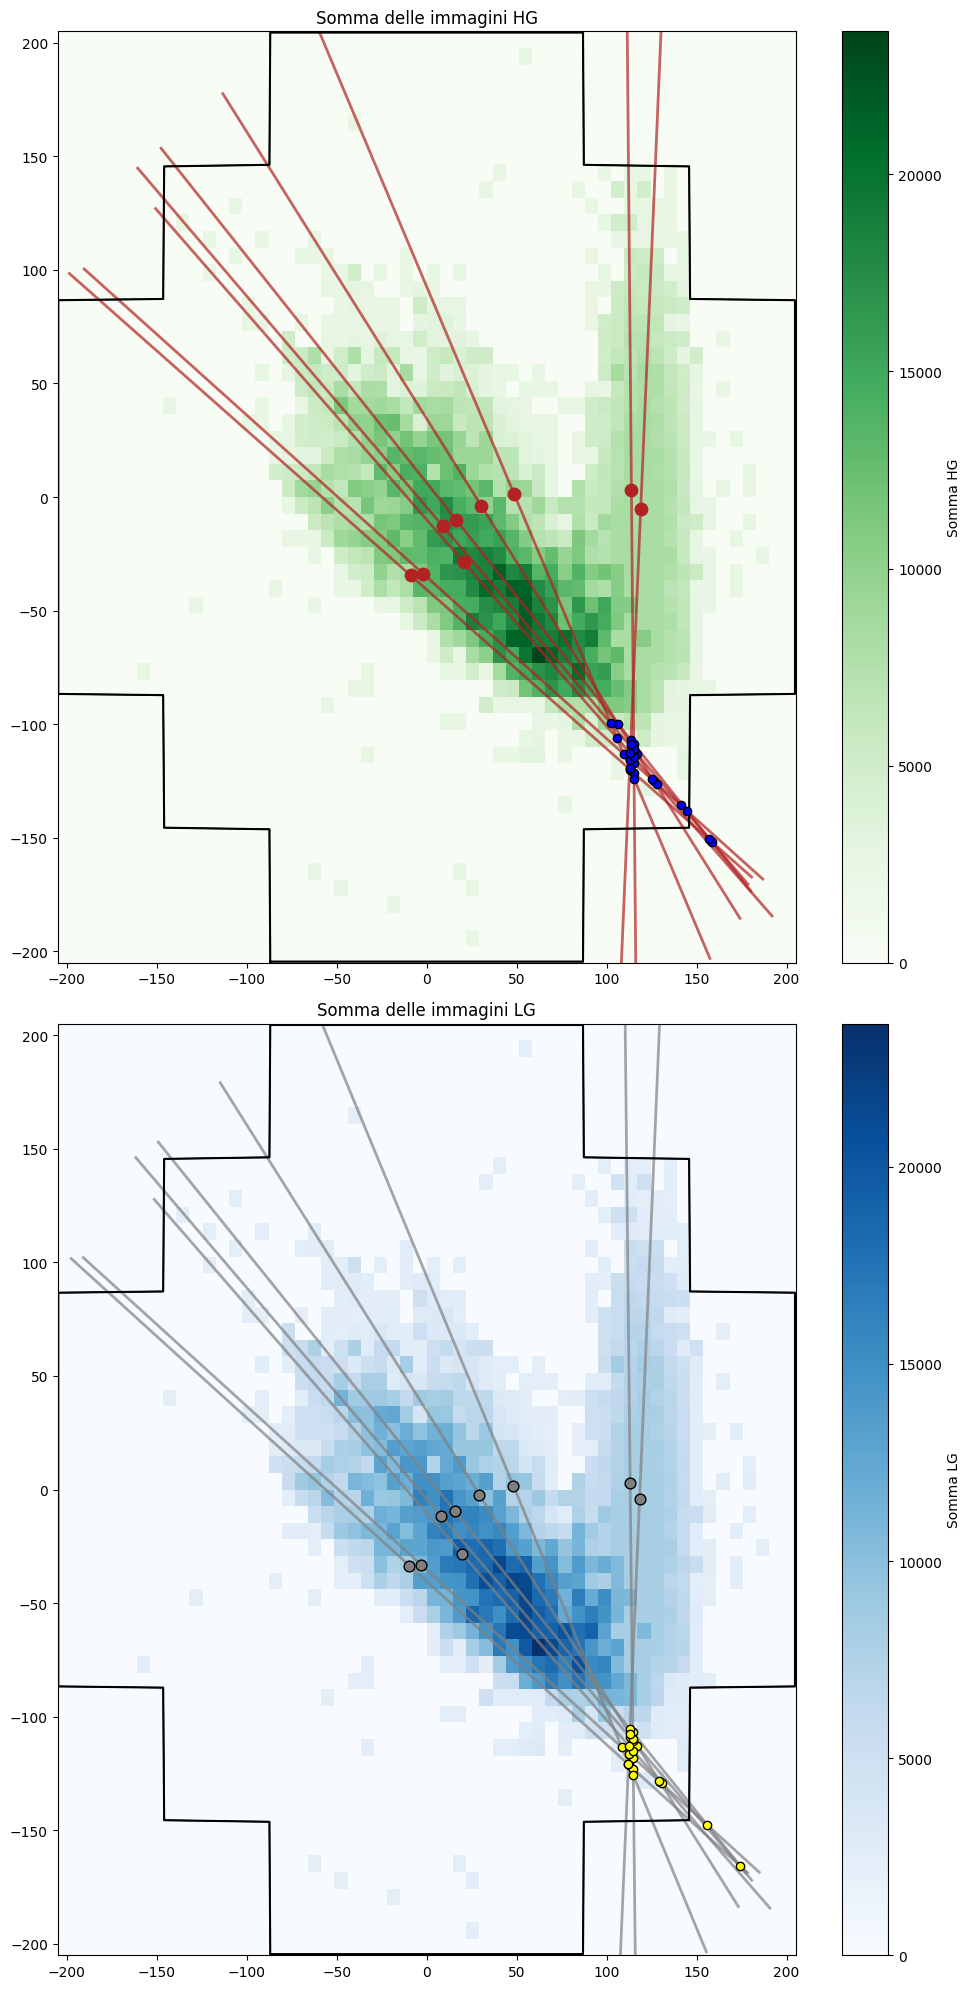

In [9]:
#somma di immagini
weights_hg = np.zeros_like(np.array(df_target['HG'])[0])
weights_lg = np.zeros_like(np.array(df_target['LG'])[0])

mask_tot = np.zeros((37, 64), dtype=bool)

fig, ax = plt.subplots(2,1,figsize=(10, 20))
ax[0].plot(xfp, yfp, 'k-', linewidth=1)
ax[1].plot(xfp, yfp, 'k-', linewidth=1)

xmin, xmax = np.min(xfp), np.max(xfp)
ymin, ymax = np.min(yfp), np.max(yfp)
diag = np.sqrt((xmax - xmin)**2 + (ymax - ymin)**2)
L = 0.4* diag
for itel in range(9):
    hgev = np.array(df_target['HG'])[itel]
    lgev = np.array(df_target['LG'])[itel]
    ttpev = np.array(df_target['TTP'])[itel]
    # filtro temporale
    pxmask =(hgev>2400) & (ttpev < 255)

    weights_hg[pxmask] += hgev[pxmask]  # somma elemento per elemento
    weights_lg[pxmask] += lgev [pxmask]

    mask_tot |= pxmask

    ttpev = np.array(df_target['TTP'])[itel]
    #centroidi
    meanx_hg = np.average(x_pix[pxmask].flatten(),weights=hgev[pxmask].flatten())
    meany_hg = np.average(y_pix[pxmask].flatten(),weights=hgev[pxmask].flatten())

    meanx_lg = np.average(x_pix[pxmask].flatten(),weights=lgev[pxmask].flatten())
    meany_lg = np.average(y_pix[pxmask].flatten(),weights=lgev[pxmask].flatten())
    #covarianze   
    cov_hg = np.cov([x_pix[pxmask].flatten(),y_pix[pxmask].flatten()],aweights=hgev[pxmask].flatten())            
    cov_lg = np.cov([x_pix[pxmask].flatten(), y_pix[pxmask].flatten()],aweights=lgev[pxmask].flatten())
            
    #print(cov_hg)
    stdx_hg,stdx_hg = np.sqrt(np.diagonal(cov_hg))
    stdx_lg,stdx_lg = np.sqrt(np.diagonal(cov_lg))

# Ellipsoid parameters from Covariance Matrix
    l1_hg=(cov_hg[0,0]+cov_hg[1,1])/2+np.sqrt( ((cov_hg[0,0]-cov_hg[1,1])/2)**2 + cov_hg[0,1]**2 )
    l2_hg= (cov_hg[0,0]+cov_hg[1,1])/2 -np.sqrt( ((cov_hg[0,0]-cov_hg[1,1])/2)**2 + cov_hg[0,1]**2 )
    theta_hg = np.arctan2(l1_hg - cov_hg[0,0], cov_hg[0,1])

    l1_lg= (cov_lg[0,0]+cov_lg[1,1])/2 + np.sqrt( ((cov_lg[0,0]-cov_lg[1,1])/2)**2 + cov_lg[0,1]**2 )
    l2_lg= (cov_lg[0,0]+cov_lg[1,1])/2 - np.sqrt( ((cov_lg[0,0]-cov_lg[1,1])/2)**2 + cov_lg[0,1]**2 )
    theta_lg = np.arctan2(l1_lg - cov_lg[0,0], cov_lg[0,1])
            #centroidi
    ax[0].scatter(meanx_hg, meany_hg, s=80, color='firebrick', zorder=5)
    ax[1].scatter(meanx_lg, meany_lg, s=60, color='grey', edgecolor='black', zorder=5)
    
            #le rette
    #HG
    x1 = meanx_hg - L*np.cos(theta_hg)
    y1 = meany_hg - L*np.sin(theta_hg)
    x2 = meanx_hg + L*np.cos(theta_hg)
    y2 = meany_hg + L*np.sin(theta_hg)
    ax[0].plot([x1, x2], [y1, y2], color='firebrick', linewidth=2, alpha=0.7)

    # LG
    x1 = meanx_lg - L*np.cos(theta_lg)
    y1 = meany_lg - L*np.sin(theta_lg)
    x2 = meanx_lg + L*np.cos(theta_lg)
    y2 = meany_lg + L*np.sin(theta_lg)
    ax[1].plot([x1, x2], [y1, y2], color='grey', linewidth=2, alpha=0.7)
    
weights_hg=np.array(weights_hg)
h1=ax[0].hist2d(x_pix[mask_tot].flatten(),y_pix[mask_tot].flatten(),
                          weights=weights_hg[mask_tot].flatten(),range=((-205, 205), (-205, 205)),
                          bins=7*8, cmap='Greens')
h2=ax[1].hist2d(x_pix[mask_tot].flatten(),y_pix[mask_tot].flatten(),
                          weights=weights_hg[mask_tot].flatten(),range=((-205, 205), (-205, 205)),
                          bins=7*8, cmap='Blues')
ax[0].plot(xfp, yfp, color='black')
ax[1].plot(xfp, yfp, color='black')
ax[0].scatter(v_hg[:,0], v_hg[:,1], marker="o",c="blue",edgecolor="black",zorder=5)
ax[1].scatter(v_lg[:,0], v_lg[:,1], marker="o",c="yellow",edgecolor="black",zorder=5)
ax[0].set_title('Somma delle immagini HG')
ax[1].set_title('Somma delle immagini LG')

cbar1 = fig.colorbar(h1[3], ax=ax[0], label='Somma HG')
cbar2 = fig.colorbar(h2[3], ax=ax[1], label='Somma LG')

plt.tight_layout()
plt.show()

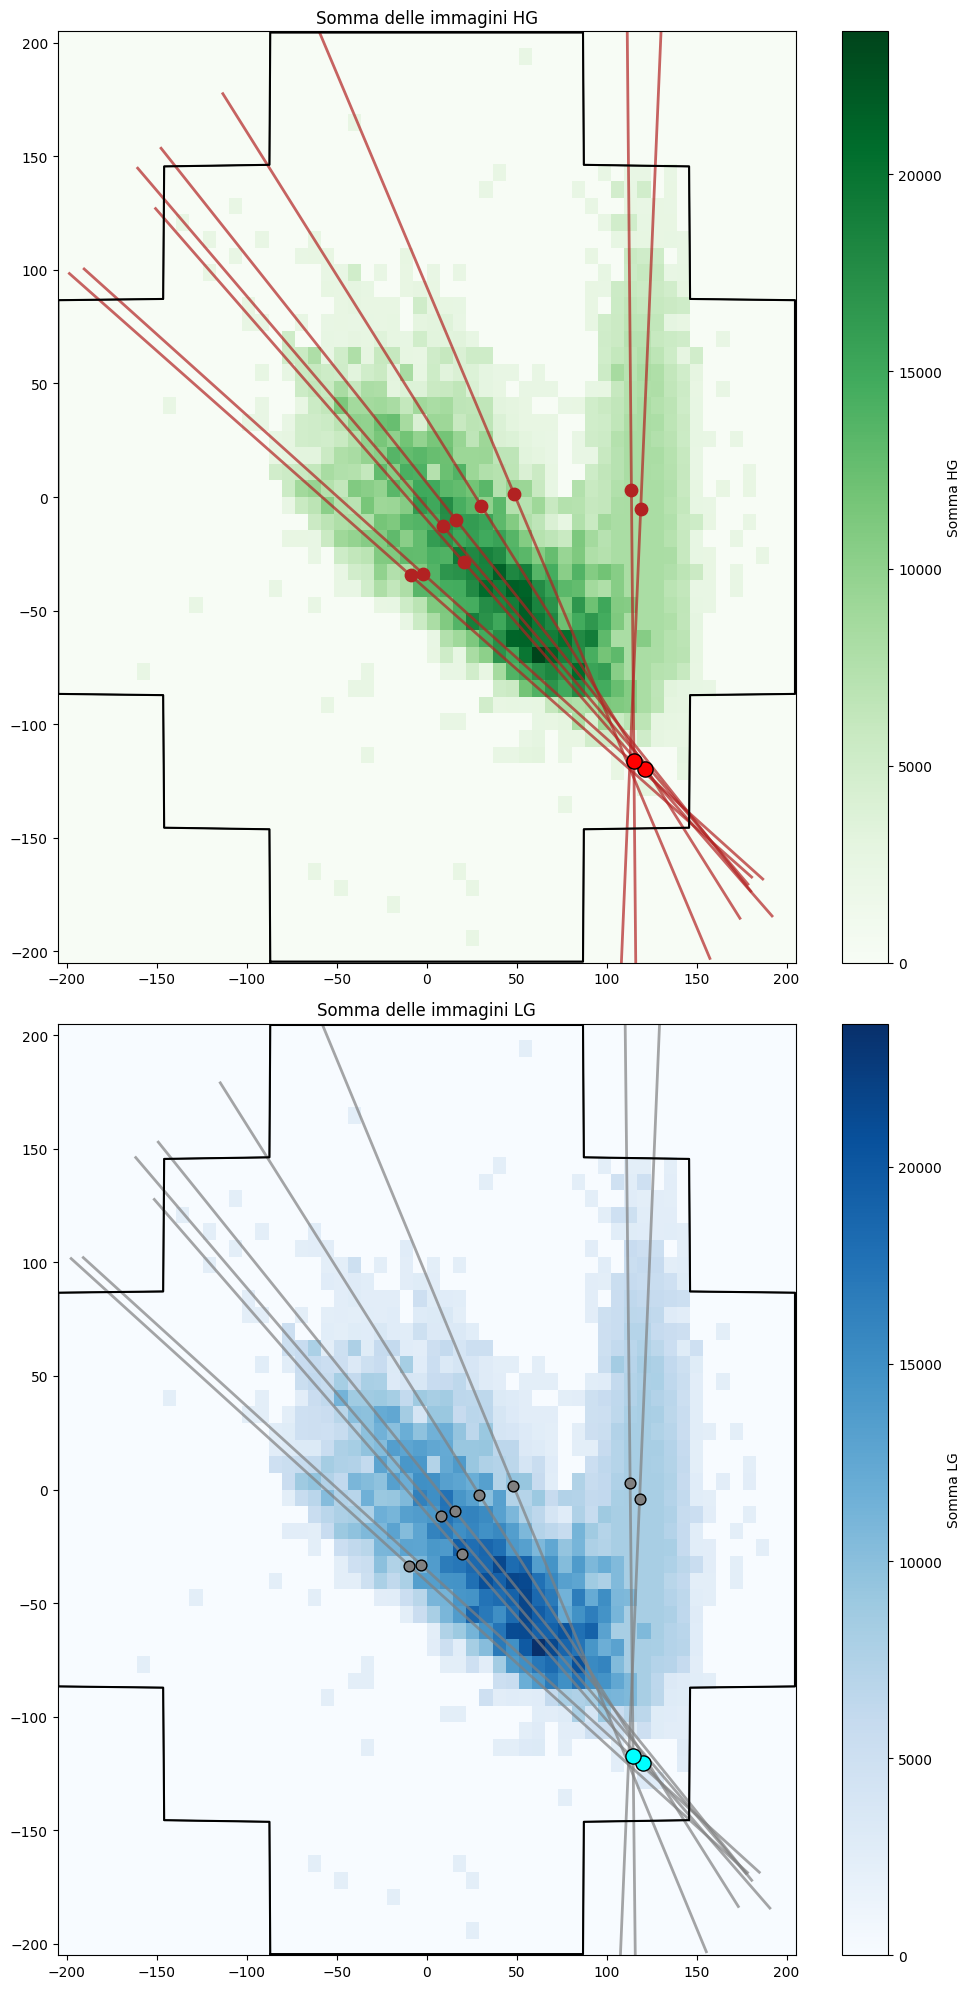

In [10]:
#somma di immagini
weights_hg = np.zeros_like(np.array(df_target['HG'])[0])
weights_lg = np.zeros_like(np.array(df_target['LG'])[0])

mask_tot = np.zeros((37, 64), dtype=bool)

fig, ax = plt.subplots(2,1,figsize=(10, 20))
ax[0].plot(xfp, yfp, 'k-', linewidth=1)
ax[1].plot(xfp, yfp, 'k-', linewidth=1)

xmin, xmax = np.min(xfp), np.max(xfp)
ymin, ymax = np.min(yfp), np.max(yfp)
diag = np.sqrt((xmax - xmin)**2 + (ymax - ymin)**2)
L = 0.4* diag
for itel in range(9):
    hgev = np.array(df_target['HG'])[itel]
    lgev = np.array(df_target['LG'])[itel]
    ttpev = np.array(df_target['TTP'])[itel]
    # filtro temporale
    pxmask =(hgev>2400) & (ttpev < 255)

    weights_hg[pxmask] += hgev[pxmask]  # somma elemento per elemento
    weights_lg[pxmask] += lgev [pxmask]

    mask_tot |= pxmask

    ttpev = np.array(df_target['TTP'])[itel]
    #centroidi
    meanx_hg = np.average(x_pix[pxmask].flatten(),weights=hgev[pxmask].flatten())
    meany_hg = np.average(y_pix[pxmask].flatten(),weights=hgev[pxmask].flatten())

    meanx_lg = np.average(x_pix[pxmask].flatten(),weights=lgev[pxmask].flatten())
    meany_lg = np.average(y_pix[pxmask].flatten(),weights=lgev[pxmask].flatten())
    #covarianze   
    cov_hg = np.cov([x_pix[pxmask].flatten(),y_pix[pxmask].flatten()],aweights=hgev[pxmask].flatten())            
    cov_lg = np.cov([x_pix[pxmask].flatten(), y_pix[pxmask].flatten()],aweights=lgev[pxmask].flatten())
            
    #print(cov_hg)
    stdx_hg,stdx_hg = np.sqrt(np.diagonal(cov_hg))
    stdx_lg,stdx_lg = np.sqrt(np.diagonal(cov_lg))

# Ellipsoid parameters from Covariance Matrix
    l1_hg=(cov_hg[0,0]+cov_hg[1,1])/2+np.sqrt( ((cov_hg[0,0]-cov_hg[1,1])/2)**2 + cov_hg[0,1]**2 )
    l2_hg= (cov_hg[0,0]+cov_hg[1,1])/2 -np.sqrt( ((cov_hg[0,0]-cov_hg[1,1])/2)**2 + cov_hg[0,1]**2 )
    theta_hg = np.arctan2(l1_hg - cov_hg[0,0], cov_hg[0,1])

    l1_lg= (cov_lg[0,0]+cov_lg[1,1])/2 + np.sqrt( ((cov_lg[0,0]-cov_lg[1,1])/2)**2 + cov_lg[0,1]**2 )
    l2_lg= (cov_lg[0,0]+cov_lg[1,1])/2 - np.sqrt( ((cov_lg[0,0]-cov_lg[1,1])/2)**2 + cov_lg[0,1]**2 )
    theta_lg = np.arctan2(l1_lg - cov_lg[0,0], cov_lg[0,1])
            #centroidi
    ax[0].scatter(meanx_hg, meany_hg, s=80, color='firebrick', zorder=5)
    ax[1].scatter(meanx_lg, meany_lg, s=60, color='grey', edgecolor='black', zorder=5)
    
            #le rette
    #HG
    x1 = meanx_hg - L*np.cos(theta_hg)
    y1 = meany_hg - L*np.sin(theta_hg)
    x2 = meanx_hg + L*np.cos(theta_hg)
    y2 = meany_hg + L*np.sin(theta_hg)
    ax[0].plot([x1, x2], [y1, y2], color='firebrick', linewidth=2, alpha=0.7)

    # LG
    x1 = meanx_lg - L*np.cos(theta_lg)
    y1 = meany_lg - L*np.sin(theta_lg)
    x2 = meanx_lg + L*np.cos(theta_lg)
    y2 = meany_lg + L*np.sin(theta_lg)
    ax[1].plot([x1, x2], [y1, y2], color='grey', linewidth=2, alpha=0.7)
    
weights_hg=np.array(weights_hg)
h1=ax[0].hist2d(x_pix[mask_tot].flatten(),y_pix[mask_tot].flatten(),
                          weights=weights_hg[mask_tot].flatten(),range=((-205, 205), (-205, 205)),
                          bins=7*8, cmap='Greens')
h2=ax[1].hist2d(x_pix[mask_tot].flatten(),y_pix[mask_tot].flatten(),
                          weights=weights_hg[mask_tot].flatten(),range=((-205, 205), (-205, 205)),
                          bins=7*8, cmap='Blues')
ax[0].plot(xfp, yfp, color='black')
ax[1].plot(xfp, yfp, color='black')
ax[0].set_title('Somma delle immagini HG')
ax[1].set_title('Somma delle immagini LG')
centro_hg=np.mean(v_hg,axis=0)
centro_lg=np.mean(v_lg,axis=0)

median_hg=np.median(v_hg,axis=0)
median_lg=np.median(v_lg,axis=0)
ax[1].scatter(centro_lg[0], centro_lg[1],zorder=5, 
                    color='cyan', edgecolor='black',
                    s=120, marker='o', label='Media delle intersezioni LG')
ax[1].scatter(median_lg[0], median_lg[1], 
                    color='cyan', edgecolor='black',zorder=5,
                    s=120, marker='o', label='Mediana della intersezioni LG')

ax[0].scatter(centro_hg[0], centro_hg[1],zorder=5, 
                    color='red', edgecolor='black',
                    s=120, marker='o', label='Media delle intersezioni HG')
ax[0].scatter(median_hg[0], median_hg[1], 
                    color='red', edgecolor='black',zorder=5,
                    s=120, marker='o', label='Mediana della intersezioni HG')

cbar1 = fig.colorbar(h1[3], ax=ax[0], label='Somma HG')
cbar2 = fig.colorbar(h2[3], ax=ax[1], label='Somma LG')
plt.tight_layout()
plt.show()

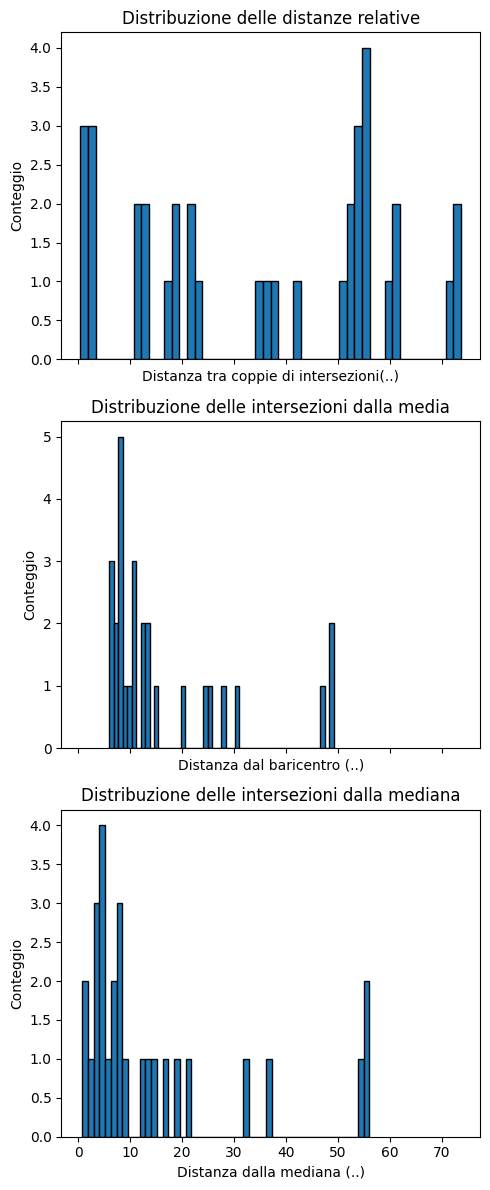

In [11]:
dists_hg = []
for i in range(N):
    for j in range(i+1, N):
        dij = np.linalg.norm(v_hg[i] - v_hg[j])
        dists_hg.append(dij)

dists_hg = np.array(dists_hg)
dists_center_hg = np.linalg.norm(v_hg - centro_hg, axis=1)
dists_median_hg=np.linalg.norm(v_hg - median_hg, axis=1)
fig, axes = plt.subplots(3, 1, figsize=(5, 12),sharex=True)
# Istogramma 1: Distanze tra coppie
axes[0].hist(dists_hg, bins=50, edgecolor='black')
axes[0].set_xlabel("Distanza tra coppie di intersezioni(..)")
axes[0].set_ylabel("Conteggio")
axes[0].set_title("Distribuzione delle distanze relative")

# Istogramma 2: Distanze dal baricentro
axes[1].hist(dists_center_hg, bins=50, edgecolor='black')
axes[1].set_xlabel("Distanza dal baricentro (..)")
axes[1].set_ylabel("Conteggio")
axes[1].set_title("Distribuzione delle intersezioni dalla media")

#istogramma 3:distanze dalla mediana
axes[2].hist(dists_median_hg, bins=50, edgecolor='black')
axes[2].set_xlabel("Distanza dalla mediana (..)")
axes[2].set_ylabel("Conteggio")
axes[2].set_title("Distribuzione delle intersezioni dalla mediana")

plt.tight_layout()
plt.show()

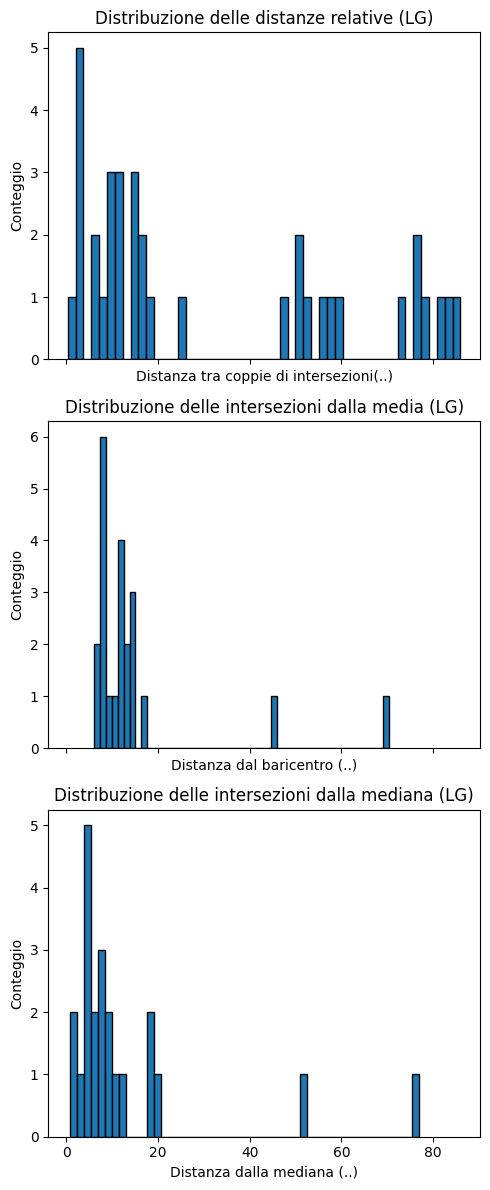

In [12]:
dists_lg = []
for i in range(N):
    for j in range(i+1, N):
        dij = np.linalg.norm(v_lg[i] - v_lg[j])
        dists_lg.append(dij)

dists_lg = np.array(dists_lg)
dists_center_lg = np.linalg.norm(v_lg - centro_lg, axis=1)
dists_median_lg = np.linalg.norm(v_lg - median_lg, axis=1)

fig, axes = plt.subplots(3, 1, figsize=(5, 12), sharex=True)

# Istogramma 1: Distanze tra coppie
axes[0].hist(dists_lg, bins=50, edgecolor='black')
axes[0].set_xlabel("Distanza tra coppie di intersezioni(..)")
axes[0].set_ylabel("Conteggio")
axes[0].set_title("Distribuzione delle distanze relative (LG)")

# Istogramma 2: Distanze dal baricentro
axes[1].hist(dists_center_lg, bins=50, edgecolor='black')
axes[1].set_xlabel("Distanza dal baricentro (..)")
axes[1].set_ylabel("Conteggio")
axes[1].set_title("Distribuzione delle intersezioni dalla media (LG)")

# Istogramma 3: Distanze dalla mediana
axes[2].hist(dists_median_lg, bins=50, edgecolor='black')
axes[2].set_xlabel("Distanza dalla mediana (..)")
axes[2].set_ylabel("Conteggio")
axes[2].set_title("Distribuzione delle intersezioni dalla mediana (LG)")

plt.tight_layout()
plt.show()


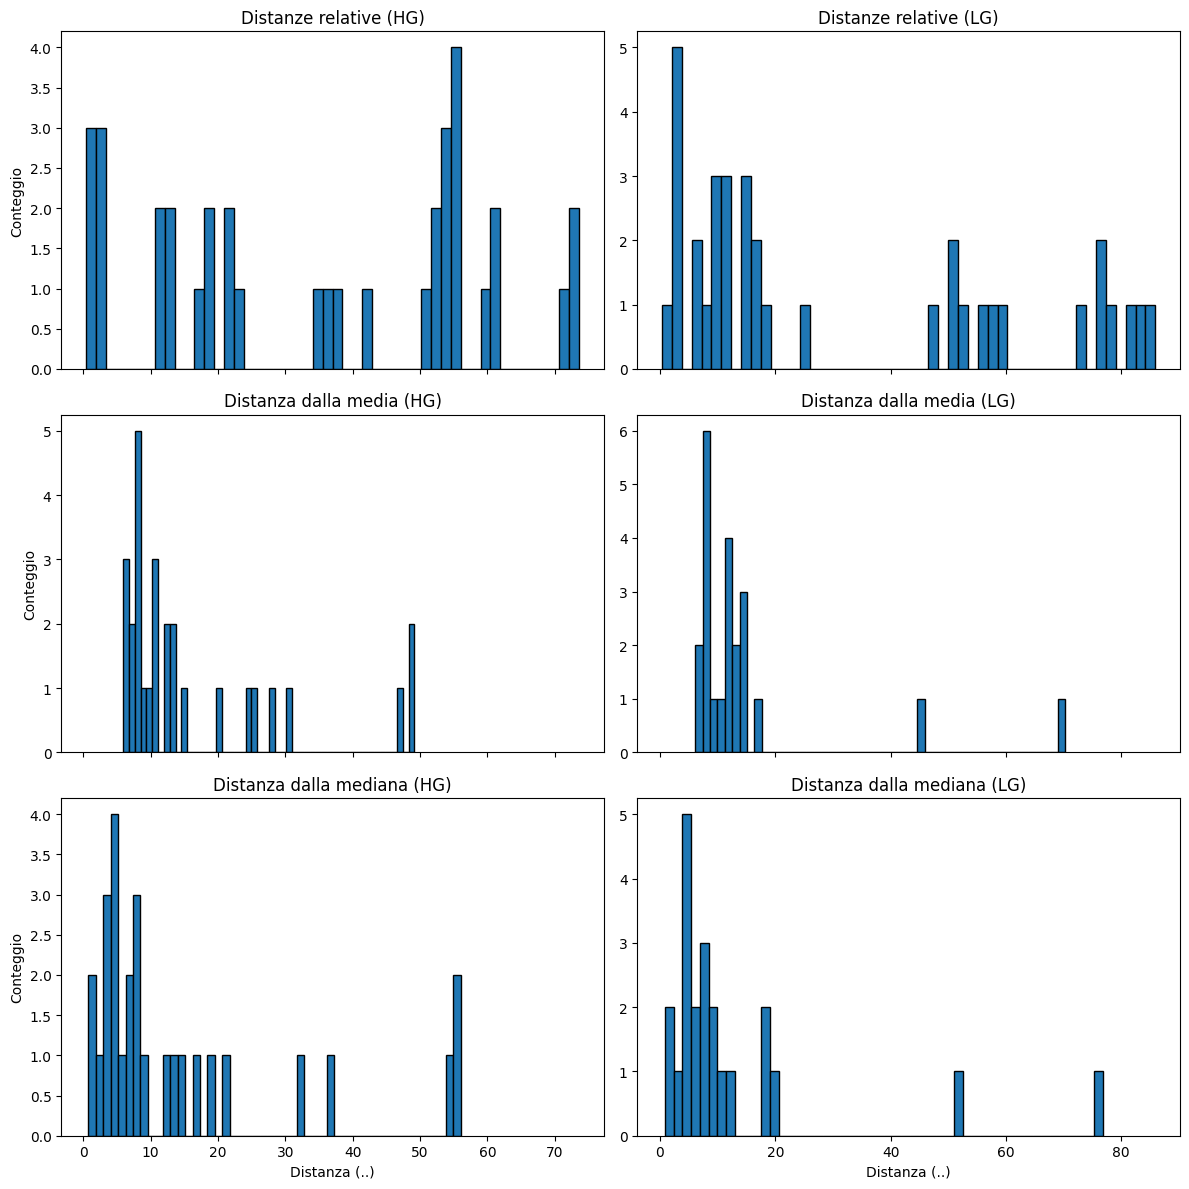

In [13]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12), sharex='col')

# -------------------- HG --------------------
#  distanze tra coppie
axes[0,0].hist(dists_hg, bins=50, edgecolor='black')
axes[0,0].set_title("Distanze relative (HG)")
axes[0,0].set_ylabel("Conteggio")

#  distanze dal baricentro
axes[1,0].hist(dists_center_hg, bins=50, edgecolor='black')
axes[1,0].set_title("Distanza dalla media (HG)")
axes[1,0].set_ylabel("Conteggio")

#  distanze dalla mediana
axes[2,0].hist(dists_median_hg, bins=50, edgecolor='black')
axes[2,0].set_title("Distanza dalla mediana (HG)")
axes[2,0].set_xlabel("Distanza (..)")
axes[2,0].set_ylabel("Conteggio")

# -------------------- LG --------------------
#  distanze tra coppie
axes[0,1].hist(dists_lg, bins=50, edgecolor='black')
axes[0,1].set_title("Distanze relative (LG)")

#  distanze dal baricentro
axes[1,1].hist(dists_center_lg, bins=50, edgecolor='black')
axes[1,1].set_title("Distanza dalla media (LG)")

#  distanze dalla mediana
axes[2,1].hist(dists_median_lg, bins=50, edgecolor='black')
axes[2,1].set_title("Distanza dalla mediana (LG)")
axes[2,1].set_xlabel("Distanza (..)")

plt.tight_layout()
plt.show()


In [14]:
#root mean square
RMS_hg = np.sqrt(np.mean(dists_hg**2))
RMS_lg = np.sqrt(np.mean(dists_lg**2))
print("RMS HG =", RMS_hg, "    RMS LG =", RMS_lg)

#median absolute deviation
MAD_hg = np.median(np.abs(dists_hg - np.median(dists_hg)))
MAD_lg = np.median(np.abs(dists_lg - np.median(dists_lg)))

print("MAD HG =", MAD_hg, "   MAD LG =", MAD_lg)


#percentile spread
p68_hg = np.percentile(dists_hg, 68)
p95_hg = np.percentile(dists_hg, 95)

p68_lg = np.percentile(dists_lg, 68)
p95_lg = np.percentile(dists_lg, 95)
print("\n")
print("HG: 68% =", p68_hg, " 95% =", p95_hg)
print("LG: 68% =", p68_lg, " 95% =", p95_lg)




RMS HG = 42.41143687947697     RMS LG = 43.193183390322055
MAD HG = 18.742819271995224    MAD LG = 12.454633872508929


HG: 68% = 53.76716676521111  95% = 72.04222488177417
LG: 68% = 51.0635934943911  95% = 81.69494080732977
